# Стратегия удержания клиентов сети фитнес-центров (проект по основам машинного обучения)

**Цель проекта** 

Выработать план действий по удержанию клиентов сети фитнес-центров.

**Входные данные** 

Клиентские анкеты.

**Заказчик исследования**

Отдел по работе с клиентами сети фитнес-центров

**Задачи проекта**

* научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;

* сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;

* проанализировать основные признаки, наиболее сильно влияющие на отток;

* разработать рекомендации по повышению качества работы с клиентами:

    1) выделить целевые группы клиентов;

    2) предложить меры по снижению оттока;

    3) определить другие особенности взаимодействия с клиентами.

<a name='contents'></a>

# Содержание исследования

## [Шаг 1. Загрузка и обзор данных](#stage_1)
## [Шаг 2. Исследовательский анализ данных](#stage_2)

* Вычисление средних значений в двух группах клиентов - тех, кто ушел в отток и тех, кто остался
* Построение столбчатых гистограмм, распределение признаков для тех, кто в оттоке и тех, кто остался
* Построение матрицы корреляции признаков
* Вывод по EDA

## [Шаг 3. Построение моделей прогнозирования оттока клиентов](#stage_3)

* Разделение данных на обучающую и валидационную выборки
* Обучение моделей
* Вывод

## [Шаг 4. Кластеризация клиентов](#stage_4)

* Создание дендограммы
* Обучение модели K-Means
* Построение гистограмм по каждому признаку для каждого кластера
* Вычисление доли оттока для каждого кластера
* Вывод

## [Шаг 5. Общий вывод и рекомендации отделу по работе с клиентами](#stage_5)



<a name='stage_1'></a>
# Шаг 1. Загрузка и обзор данных
[Назад к оглавлению](#contents)

Импортируем библиотеки для проекта

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import itertools
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Загрузка файла c данными

In [2]:
df = pd.read_csv('data/gym_churn.csv') 

Смотрим на данные: ссылка на переменную покажет и голову и хвост

In [3]:
df

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,1,1,0,1,12,0,33,2.406023,12.0,8,2.284497,2.349070,0
3996,0,1,0,0,1,1,1,29,68.883764,1.0,1,1.277168,0.292859,1
3997,1,1,1,1,1,12,0,28,78.250542,11.0,2,2.786146,2.831439,0
3998,0,1,1,1,1,6,0,32,61.912657,5.0,3,1.630108,1.596237,0


## Описание данных согласно документации

Набор данных включает следующие поля:

* Данные клиента за предыдущий до проверки факта оттока месяц:

    * 'gender' — пол;
    * 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
    * 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
    * Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
    * 'Phone' — наличие контактного телефона;
    * 'Age' — возраст;
    * 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).


* Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:

    * 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
    * 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
    * 'Group_visits' — факт посещения групповых занятий;
    * 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
    * 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
    * 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
    * 'Churn' — факт оттока в текущем месяце.

Посмотрим на общую информацию о датасете.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Удобно, чтобы все названия столбцов были в нижнем регистре.

In [5]:
df.columns = df.columns.str.lower()
df.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

Проверка на наличие дубликатов в данных

In [6]:
f'Количество дубликатов в данных: {df.duplicated().sum()}'

'Количество дубликатов в данных: 0'

Проверка, какая длительность абонементов представлена - в описании говорится, что 1 месяц, 6 месяцев и 1 год.

In [7]:
df['contract_period'].sort_values().unique()

array([ 1,  6, 12])

Все сходится.

## Вывод

* В данных 4000 наблюдений (строк) и 14 признаков (столбцов). 

* Пропущенных значений нет. 
    
* Дубликаты отсутствуют.

* В данных присутствуют только числовые переменные. 

* Тип данных у всех объектов соответствует ожиданиям. 
    
* Бинарными признаками (со значениями 0 или 1) являются: gender, near_Location, partner, promo_friends, phone, age, group_visits, churn.

<a name='stage_2'></a>
# Шаг 2. Исследовательский анализ данных

[Назад к оглавлению](#contents)    

In [8]:
pd.set_option('display.float_format', '{:.2f}'.format)

Посмотрим на средние значения и стандратные отклонения данных с помощью метода describe().

In [9]:
df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00
mean,0.51,0.85,0.49,0.31,0.90,4.68,0.41,29.18,146.94,4.32,3.72,1.88,1.77,0.27
std,0.50,0.36,0.50,0.46,0.30,4.55,0.49,3.26,96.36,4.19,3.75,0.97,1.05,0.44
min,0.00,0.00,0.00,0.00,0.00,1.00,0.00,18.00,0.15,1.00,0.00,0.00,0.00,0.00
25%,0.00,1.00,0.00,0.00,1.00,1.00,0.00,27.00,68.87,1.00,1.00,1.18,0.96,0.00
50%,1.00,1.00,0.00,0.00,1.00,1.00,0.00,29.00,136.22,1.00,3.00,1.83,1.72,0.00
75%,1.00,1.00,1.00,1.00,1.00,6.00,1.00,31.00,210.95,6.00,5.00,2.54,2.51,1.00
max,1.00,1.00,1.00,1.00,1.00,12.00,1.00,41.00,552.59,12.00,31.00,6.02,6.15,1.00


Посмотрим, как соотносятся классы набора данных

In [10]:
print('Соотношение классов:\n', df['churn'].value_counts())

Соотношение классов:
 0    2939
1    1061
Name: churn, dtype: int64


Классы не сбалансированы. 

Количесто клиентов в оттоке составляет 1061, тех, кто остался, больше чем в 2 раза  - 2939. 

## Промежуточный вывод

* Среди клиентов мужчин и женщин примерно поровну (среднее значение бинарного признака близко к 0.5)

* Примерно 85% клиентов посещают фитнес-центр рядом с домом (среднее значение бинарного признака - 0.85)

* Клиентов сотрудников компании-партнера сети примерно половина - среднее значение бинарного признака 0.49.

* В рамках акции Приведи друга в фитнес клуб записалось лишь 31% клиентов.

* Контактный номер телефона оставили 90% клиентов.

* Длительность действующего абонемента у клиентов следующая - минимальная 1 месяц, максимальная - 12 месяцев. В данных представлены только абонементы на 1, 6, 12 месяцев. В среднем длительность 4-5 месяцев. 50 % клиентов имеют абонемент на 1 месяц.
    
*  41%  клиентов посещают групповые занятия.

* Средний возраст клиентов фитнес-центров - 29.  Максимальный возраст клиентов сети -  41 год. Самый "молодой" посетитель имеет возраст 18 лет. 75% клиентов - в возрасте 31 год и младше.

* В среднем клиенты тратят на доп услуги 146 денежных единиц. Но стандартное отклонение довольно высокое, разброс данных большой. 

* До окончания текущего абонемента в среднем остается 4.3 месяца.
 
* В среднем с момента первого обращения в фитнес-центр проходит 3.7 месяца.

* Средняя частота посещений в неделю за все время с начала действия абонемента - 1-2 раза.

* Средняя частота посещений в неделю за предыдущий месяц - 1-2 раза. 

* Утекают 27% клиентов по данным за предыдущий месяц. Группы (лояльных и тех, кто уходит в отток) не сбалансированы. Лояльных значительно больше.


## Cредние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался

In [12]:
df_mean = df.groupby('churn').mean().T
df_mean

churn,0,1
gender,0.51,0.51
near_location,0.87,0.77
partner,0.53,0.36
promo_friends,0.35,0.18
phone,0.90,0.90
contract_period,5.75,1.73
group_visits,0.46,0.27
age,29.98,26.99
avg_additional_charges_total,158.45,115.08
month_to_end_contract,5.28,1.66


### Промежуточный вывод

* Среди тех клиентов, кто ушел, гораздо меньше таких, кто работает в компании-партнере клуба (среднее близко к 0.4).

* В среднем длительность абонемента у людей, ушедших в отток, составляет 1.7 месяцев, а у оставшихся клиентов -  5.7 месяцев. То есть уходят в большей степени те, у кого невысока длительность абонемента.

* Так же большой разрыв среди лояльных и нет по сроку окончания текущего абонемента. У ушедших в отток он в среднем составляем -1.6 месяцев, а у лояльных клиентов - 5.2 месяцев. То есть в отток склонны больше уходить те, у кого скоро истекает действие абонемента. 

* Время с момента первого обращения в фитнес-центр для уходящих в отток равно примерно 1 месяцу, а для тех, кто остался, чуть больше 5 месяцев. Значит лояльные первые месяцы клиенты, скорее всего, не уйдут в отток после длительного периода пользования услугами фитнес-центра.

* Среди клиентов в оттоке совсем мало людей, посещающих групповые занятия (среднее около 0.3 в сравнении с группой лояльных, где около 0.5). 

* Клиенты в оттоке значительно меньше тратят на дополнительные услуги в фитнес-центре - в среднем 115 денежных единиц, в то время как лояльные клиенты - в среднем тратят 158 д.е. 

* Средняя частота посещения фитнес клуба за месяц и за весь период с начала действия абонемента между двумя группами не особо различается: для лояльных в среднем - 2 раза в неделю, для ушедших в отток: 1-2 раза в неделю.

* По другим признакам значительной разницы между группами не наблюдается.

## Cтолбчатые гистограммы и распределения признаков для тех, кто ушёл в отток и тех, кто остался

Создадим две выборки: клиенты, ушедшие в отток (`churn_clients`), и клиенты, которые остались (`loyal_clients`)

In [13]:
churn_clients = df[df['churn']==1]
loyal_clients = df[df['churn']==0]

Строим столбчатые диаграммы, чтобы оценить распределение признаков для обоих групп клиентов. 

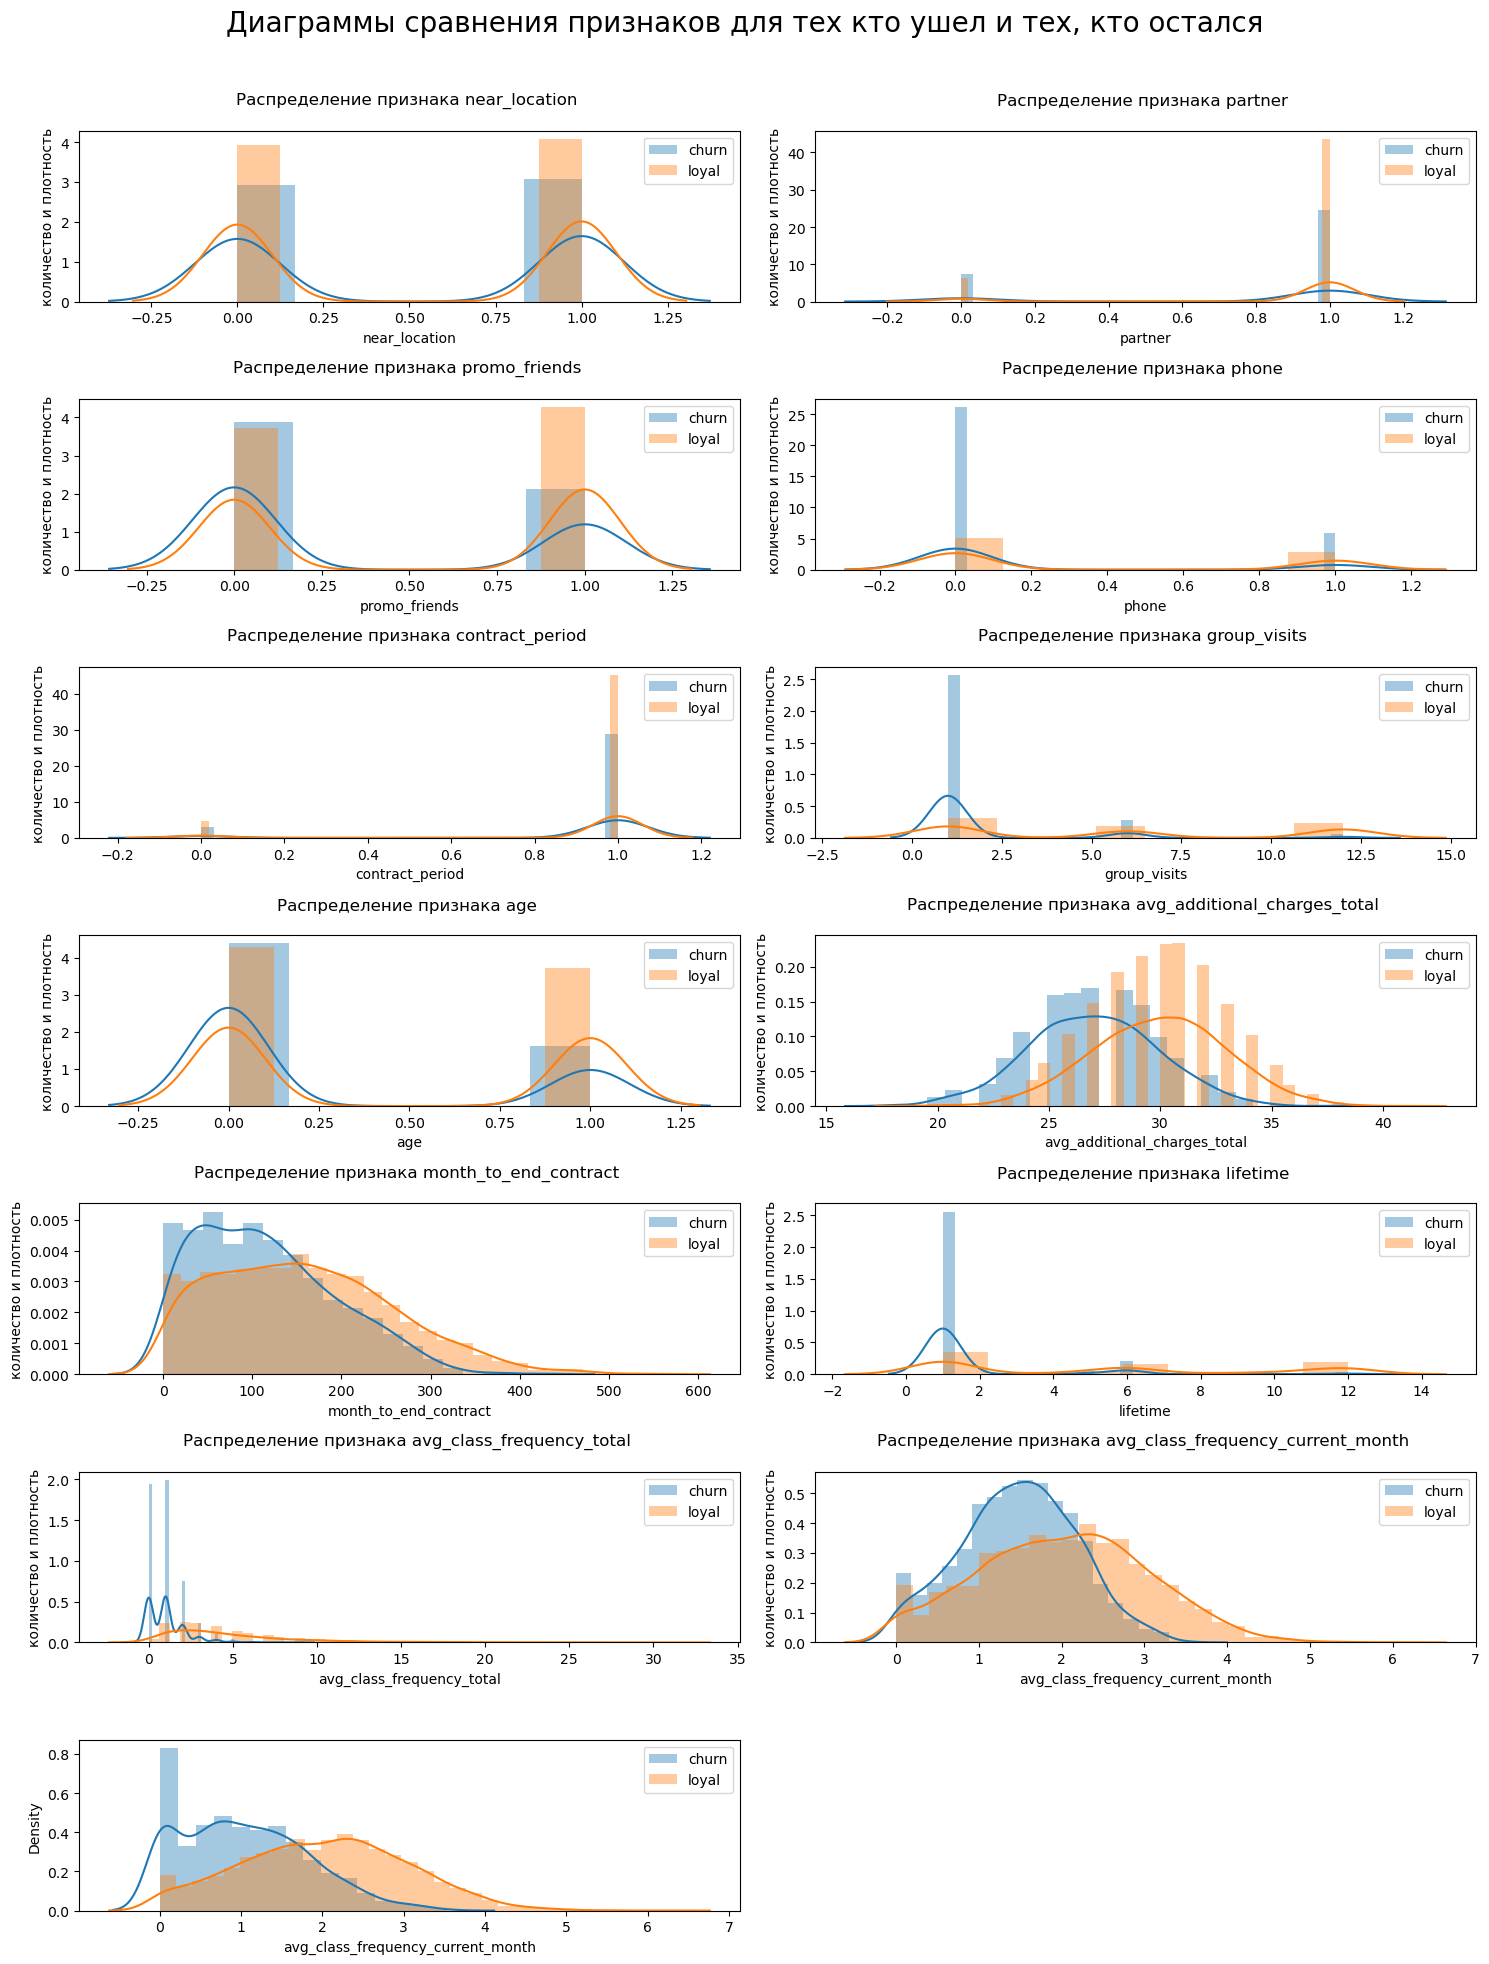

In [14]:
plt.figure(figsize=(15, 20))

for i, col in enumerate(df.drop('churn', axis = 1).columns):
    plt.title("Распределение признака {} \n".format(col))
    plt.xlabel(col)
    plt.ylabel("количество и плотность")
    plt.subplot(7, 2,i+1)
    sns.distplot(churn_clients[col], label='churn')
    sns.distplot(loyal_clients[col], label='loyal')
    plt.legend()

plt.suptitle('Диаграммы сравнения признаков для тех кто ушел и тех, кто остался\n\n', fontsize=20)
plt.tight_layout()
plt.show()

### Промежуточный вывод

* По полу, близости к фитнес-центру и наличию контактного телефона и лояльные клиенты, и ушедшие в отток имеют схожее равномерное распределение.

* По среднему возрасту обе группы имеют нормальное распределение, значения для лояльных клиентов немного смещены вправо (чуть старше), а для ушедших клиентов - влево (чуть моложе).

* Наблюдается различие в распределении признака "сотрудник компании-партнера". В группе лояльных клиентов число сотрудников компании-партнера клуба явно больше, чем среди тех, кто уходит в отток. 

* Различия в распределении групп по посещению групповых занятий такие же, как и в распределении признака "сотрудник компании-партнера".

* Распределение длительности текущего абонемента по лояльным клиентам и ушедшим различается. 
Среди ушедших в отток клиентов практически нет таких, у которых бы был абонемент на 12 месяцев, в то время как для лояльных клиентов абонемент со сроком действия на 12 месяцев, занимает второе место по популярности после абонемента на 1 месяц, 
который популярен для обеих групп.  

* Различия в распределении групп по сроку до окончания действующего абонемента такие же, как и в распределении по длительности абонемента.

* Распределение признака времени с момента первого обращения для ушедших в отток клиентов сильно смещено влево и практически не имет высоких значений. Для лояльных клиентов этот признак принимает более высокие значения.

## Построим матрицу корреляций признаков

Вычисляем матрицу корреляций

In [16]:
cm = df.corr()

Строим тепловую карту

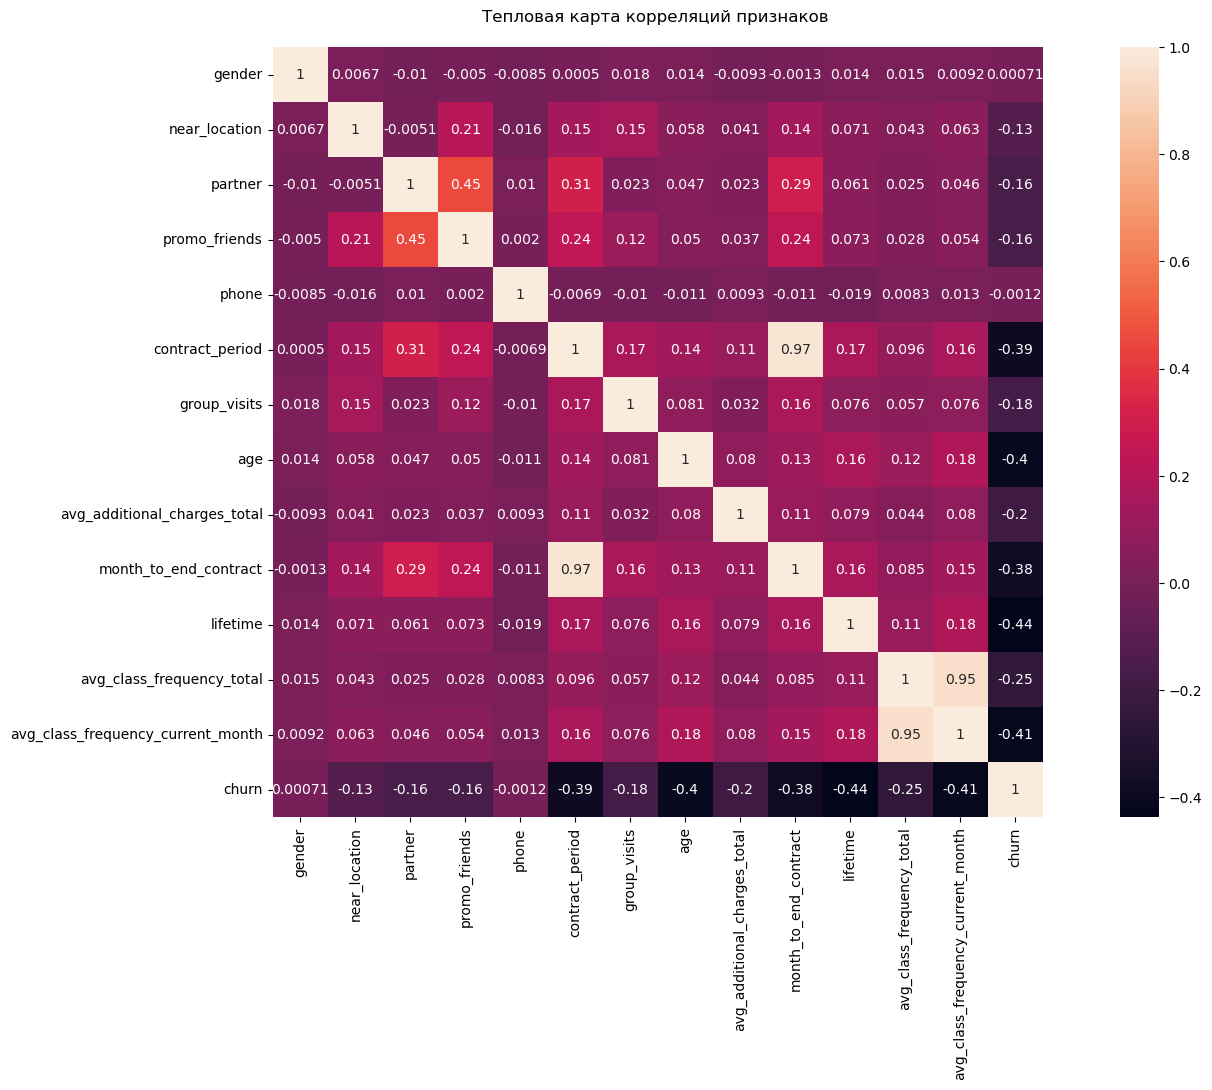

In [17]:
plt.figure(figsize=(20, 10))
sns.heatmap(cm, annot=True, square=True);
plt.title('Тепловая карта корреляций признаков \n')
plt.show();

<a id='corr'></a>
### Промежуточный вывод

* Сильной связи между показателем оттока и другими признаками не выявлено. 

* Наблюдается сильная корреляция между длительностью текущего абонемента (contract_period) и сроком до окончания текущего абонемента (month_to_end_contract). Скорее всего, это связано с тем, что в данных представлены клиенты, отобранные на определенном этапе покупки абонемента.  

* Также наблюдается сильная корреляция между средней частотой посещений в неделю с начала действия абонемента (avg_class_frequency_total) и за предыдущий месяц (avg_class_frequency_current_month). Видимо, это говорит о том, что пользователи посещяют примерно одинаковое количество раз в неделю вне зависимости от того, как долго они пользуются абонементом.

## Общий вывод по исследовательскому анализу

* В данных отсутствуют пропуски. Всего 4000 наблюдений по 14 признакам. 

* У нас есть данные о 4000 клиентов. Из них 27 % клиентов ушли в отток по представленным данным за текущий месяц. 

* Сильно влияющих признаков на факт оттока клиентов по результатам EDA не выявлено. 

* В среднем длительность абонемента у людей, ушедших в отток, составляет 1.7 месяцев, а у тех, кто остался  - 5.7 месяцев. То есть уходят в большей степени те, у кого невысока длительность абонемента.

* Так же выявлен большой разрыв среди лояльных клиентов и ушедших в отток по сроку окончания текущего абонемента. У ушедших в отток в среднем до срока окончания абонемента остается -1.6 месяцев, а у лояльных клиентов - 5.2 месяцев. То есть в отток склонны больше уходить те, у кого скоро истекает абонемент.

* Время с момента первого обращения в фитнес-центр для уходящих в отток равно примерно 1 месяцу, а для тех, кто остался, чуть больше 5 месяцев. Значит лояльные первые месяцы клиенты, скорее всего, не уйдут в отток после длительного периода пользования услугами фитнес-центра.

* Среди тех клиентов, кто ушел, гораздо меньше таких, кто работает в компании-партнере клуба (среднее около 0.4).

* Среди ушедших в отток клиентов совсем мало тех, кто посещает групповые занятия (среднее около 0.3 в сравнении с группой лояльных, где около 0.5) и практически нет таких, которые бы приобретали абонемент на 12 месяцев. 

* Ярких различий по возрасту, полу, близости к фитнес-клубу для обеих групп (лояльных и ушедших в отток) не выявлено.

<a name='stage_3'></a>
# Шаг 3. Модели прогнозирования оттока клиентов
[Назад к оглавлению](#contents)

У нас всего два класса: 0 (клиент остался) и 1 (клиент ушел в отток). Наша целевая переменная churn - бинарная величина. Перед нами задача бинарной классификации. 

## Разделение данных на обучающую и валидационную выборки 

In [18]:
# Разделим данные на признаки (матрица X) и целевую переменную (y)
X = df.drop('churn', axis = 1)
y = df['churn']

# Разделим выборку на обучающую и валидационную в соотношении 80:20.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

## Обучение моделей

Популярный алгоритм машинного обучения для решения задач бинарной классификации - **логистическая регрессия**. 

Мы не будем удалять из обучающей выборки один из пары сильно коррелирующих признаков, потому что в алгоритм логистической регрессии регуляризация встроена по умолчанию (параметр solver='liblinear' действует по умолчанию). 

Создадим функцию для генерации метрик.

Определим функцию, которая будет выводить наши метрики

In [19]:
def print_all_metrics(model, y_true, y_pred, y_proba):
    print('Метрики модели {}'.format(model))
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

Создадим функцию для обучения и прогноза моделей, для вывода метрик используем функцию print_all_metrics выше.

In [20]:
def make_prediction(m, train_features, train_targets, test_features, test_targets):
    model =  m 
    model.fit(train_features, train_targets)
    predictions = model.predict(test_features)
    probabilities = model.predict_proba(test_features)[:,1]
    print_all_metrics('Метрики модели {}:\n'.format(m), test_targets, predictions, probabilities)
    return model

In [24]:
log_reg_model = make_prediction(LogisticRegression(random_state=0),X_train, y_train, X_test, y_test)


Метрики модели Метрики модели LogisticRegression(random_state=0):

	Accuracy: 0.92
	Precision: 0.89
	Recall: 0.81
	F1: 0.85
	ROC_AUC: 0.97


Обучаем модель **логистической регрессии без стандартизации признаков**

Обучим модель алгоритмом **случайного леса (Random Forest) без стандартизации признаков**

In [25]:
rf_model = make_prediction(RandomForestClassifier(random_state=0), X_train, y_train, X_test, y_test)

Метрики модели Метрики модели RandomForestClassifier(random_state=0):

	Accuracy: 0.92
	Precision: 0.88
	Recall: 0.83
	F1: 0.85
	ROC_AUC: 0.97


Проведем стандартизацию и снова обучим модели.

In [26]:
# Cтандартизируем и нормализируем данные
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

Обучаем модель **логистической регрессии со стандартизации признаков**

In [27]:
log_reg_st_model = make_prediction(LogisticRegression(random_state=0), X_train_st, y_train, X_test_st, y_test)

Метрики модели Метрики модели LogisticRegression(random_state=0):

	Accuracy: 0.94
	Precision: 0.90
	Recall: 0.85
	F1: 0.87
	ROC_AUC: 0.98


Обучим модель алгоритмом **случайного леса (Random Forest) со стандартизацией признаков**

In [24]:
rf_st_model = make_prediction(RandomForestClassifier(random_state=0), X_train_st, y_train, X_test_st, y_test)

Метрики модели Метрики модели RandomForestClassifier(random_state=0):

	Accuracy: 0.92
	Precision: 0.88
	Recall: 0.83
	F1: 0.85
	ROC_AUC: 0.97


Посмотрим на значения коэффициентов, соответствующих оптимальной функции в лучшей модели.

In [28]:
# создадим датафрейм с признаками и их весами
features = pd.DataFrame({'feature': X_train.columns, 'coeff': log_reg_st_model.coef_[0]})
features['coeff_abs'] = features['coeff'].abs()

# выводим упорядоченный по модулю коэффициентов датафрейм с признаками
features.sort_values(by='coeff_abs', ascending=False)

,feature,coeff,coeff_abs
12,avg_class_frequency_current_month,-4.21,4.21
10,lifetime,-3.58,3.58
11,avg_class_frequency_total,3.11,3.11
7,age,-1.17,1.17
5,contract_period,-0.70,0.70
9,month_to_end_contract,-0.63,0.63
8,avg_additional_charges_total,-0.57,0.57
6,group_visits,-0.40,0.40
3,promo_friends,-0.14,0.14
2,partner,-0.07,0.07


Довольно высокий вес у avg_class_frequency_current_month, а он сильно коррелирует с avg_additional_charges_total. 
Попробуем таки обучить модель логистической регрессии, удалив сильно коррелирующие признаки вручную, и посмотрим на результат.

In [29]:
# Создаем новую матрицу признаков, без сильно коррелирующих
X_dr = df.drop(['month_to_end_contract', 'avg_class_frequency_current_month', 'churn'], axis = 1)

# Разделим выборку на обучающую и валидационную в соотношении 80:20.
X_train_dr, X_test, y_train, y_test = train_test_split(X_dr, y, test_size=0.2, stratify=y, random_state=0)

# Cтандартизируем и нормализируем данные
scaler = StandardScaler()
X_train_st_dr = scaler.fit_transform(X_train_dr)
X_test_st = scaler.transform(X_test)

log_reg_st_model_dr = make_prediction(LogisticRegression(random_state=0), X_train_st_dr, y_train, X_test_st, y_test)

Метрики модели Метрики модели LogisticRegression(random_state=0):

	Accuracy: 0.91
	Precision: 0.83
	Recall: 0.83
	F1: 0.83
	ROC_AUC: 0.96


Результат сильно хуже.

Попробуем еще поискать лучшую модель с помощью GreadSearchCV

In [30]:
#Зададим гиперпараметры для перебора для логистической регрессии: 
    
parameters = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear']
}

# Обучаем модель и перебираем гиперпараметры
logreg = LogisticRegression(random_state=0)


logreg_grid = GridSearchCV(logreg,            # модель
                   param_grid = parameters,   # гиперпараметры
                   scoring='f1',        # метрика оценки качества модели  
                   cv=10)

logreg_grid.fit(X_train_st, y_train) 


print("Лучшие параметры модели:",logreg_grid.best_params_)
print("F1:", logreg_grid.best_score_)

Лучшие параметры модели: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
F1: 0.8588310551385085


На самом деле GridSearch оказался не особо эффективен в данном случае. С параметрами по умолчанию (C=1.0, penalty=l2, solver=lbfgs) модель логистической регрессии показывает результат чуть лучше (0.87 против 0.86).

Посмотрим, что покажет GreadSearchCV для алгоритма RandomForestClassifier

In [31]:
#Зададим гиперпараметры для перебора для модели случайного леса: 
    
rf_parameters = {
    'n_estimators': [200, 500], 
    'max_depth': [4,6]
    #'criterion'  : ['entropy', 'gini']
}

# Обучаем модель и перебираем гиперпараметры
rf = RandomForestClassifier(random_state=0)

rf_grid = GridSearchCV(rf,            # модель
                   param_grid = rf_parameters,   # гиперпараметры
                   scoring='f1',        # метрика оценки качества модели  
                   cv=10)

rf_grid.fit(X_train_st, y_train) 


print("Лучшие параметры модели:",rf_grid.best_params_)
print("F1:", rf_grid.best_score_)

Лучшие параметры модели: {'max_depth': 6, 'n_estimators': 500}
F1: 0.8120062695272239


GridSearch для случайного леса тоже не оказался эффективным. Параметры по умолчанию со стандартизацией признаков показали по F1 -  0.85.

## Вывод

* В нашем случае метрика accuracy не особо работает: у нас классы не сбалансированные. Поэтому нам интересны метрики Precision и Recall, сводная метрика F1, учитывающая баланс между точностью и полнотой и ROC_AUC. 

* Обе модели хорошо прогнозируют отток на валидационной выборке, но логистическая регрессия со стандартизацией признаков показала себя чуть лучше (без удаления сильно коррелирующих признаков вручную): 

Точность: 0.90

Полнота: 0.85

F1-мера: 0.87

Метрика ROC_AUC: 0.98

<a name='stage_4'></a>
# Шаг 4. Кластеризация клиентов
[Назад к оглавлению](#contents)

Для задачи кластеризации необходимо иметь стандартизированные данные.

In [32]:
#создадим объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler()
#обучаем scaler и одновременно трансформируем матрицу для признаков
X_st = scaler.fit_transform(X) 

## Дендрограмма

Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму.

In [33]:
# В переменной linked сохраняем таблицу «связок» между объектами. Её можно визуализировать как дендрограмму:
linked = linkage(X_st, method = 'ward')

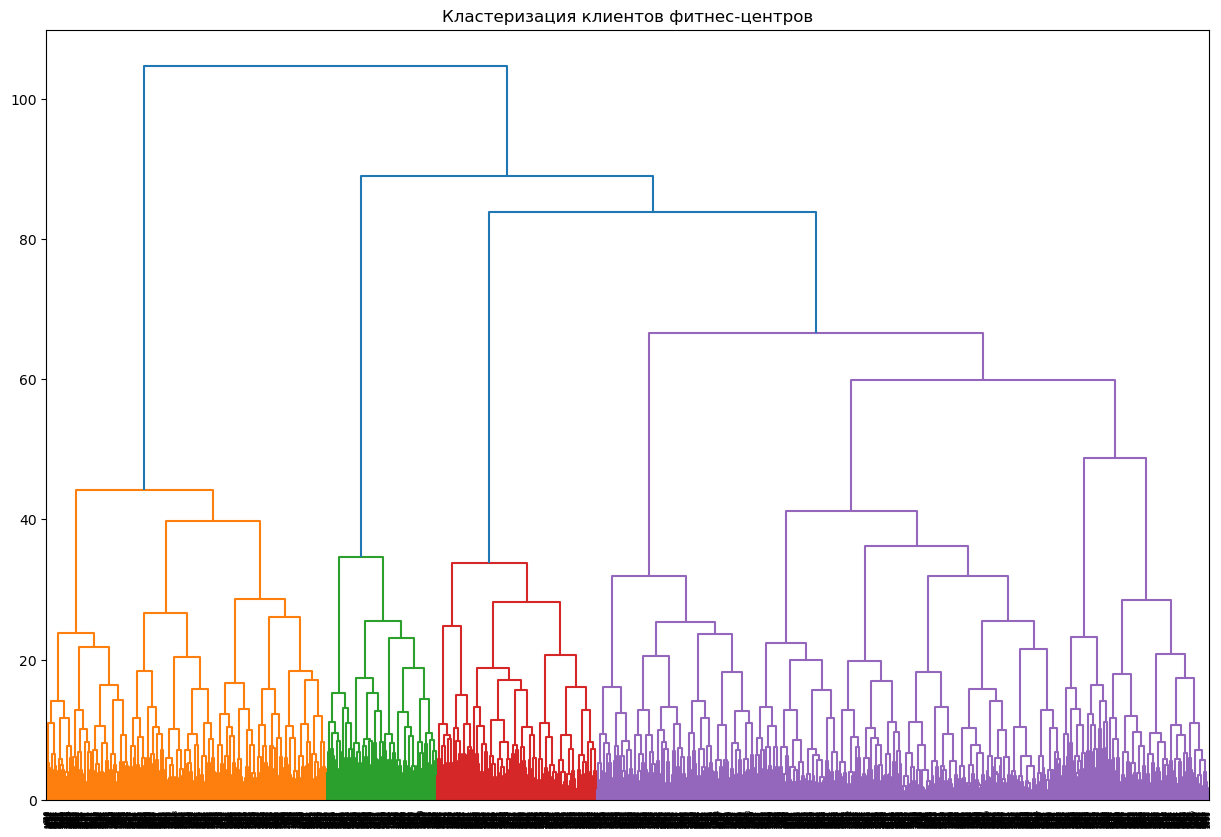

In [34]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Кластеризация клиентов фитнес-центров')
plt.show()

Согласно данной дендрограмме можно предположить наличие четырёх кластеров клиентов.

## Обучение модели K-Means

Обучим модель кластеризации с помощью алгоритма K-Means (обучение без учителя) и спрогнозируем кластеры клиентов.

Для прогноза кластеров клиентов используем пять кластеров.

Чтобы избежать проблемы мультиколлинеарности, удалим из нашей выборки признаки month_to_end_contract и avg_class_frequency_current_month (коррелирующие пары признаков мы обнаружили в данном проекте [ранее](#corr)). А также удалим столбец 'churn': наша модель должна уметь кластеризовать и новых клиентов, у которых мы еще не знаем значение признака churn.


In [35]:
#Удаляем столбцы 'Month_to_end_contract', 'Avg_class_frequency_current_month' и столбец с оттоком 'churn'
df_for_km = df.drop(['month_to_end_contract', 'avg_class_frequency_current_month', 'churn'], axis = 1)

# стандартизируем данные
scaler = StandardScaler()
X_st = scaler.fit_transform(df_for_km) 

# Задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters=5, random_state=0)

# Применяем алгоритм к данным и формируем вектор кластеров
labels = km.fit_predict(X_st)

# Сохраняем метки кластера в поле нашего датасета
df['cluster_km'] = labels

Для удобства изменим названия кластеров

In [36]:
df.loc[df['cluster_km']==0, 'cluster_km'] = 'cluster_1'
df.loc[df['cluster_km']==1, 'cluster_km'] = 'cluster_2'
df.loc[df['cluster_km']==2, 'cluster_km'] = 'cluster_3'
df.loc[df['cluster_km']==3, 'cluster_km'] = 'cluster_4'
df.loc[df['cluster_km']==4, 'cluster_km'] = 'cluster_5'

Смотрим на средние значения наших признаков для каждого кластера

In [38]:
df.groupby(['cluster_km']).mean().T

cluster_km,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5
gender,0.50,0.49,0.51,0.54,0.52
near_location,0.00,1.00,1.00,1.00,0.86
partner,0.49,0.96,0.24,0.25,0.47
promo_friends,0.08,0.89,0.06,0.08,0.31
phone,1.00,1.00,1.00,1.00,0.00
contract_period,3.03,7.66,2.82,4.53,4.78
group_visits,0.24,0.46,0.00,1.00,0.43
age,28.72,29.54,28.77,29.54,29.30
avg_additional_charges_total,137.54,155.86,143.38,148.09,144.21
month_to_end_contract,2.85,6.99,2.65,4.17,4.47


По некоторым признакам есть четко отделяемые группы, к примеру: клиенты кластера 1 характеризуются тем, что посещают фитнес-центр не в районе дома или работы. И доля оттока у них самая высокая. Или клиенты кластера 2 характеризуются высокой долей клиентов-сотрудников компаний-партнеров клуба, самым длительным сроком абонемента. 

Но для более детального анализа посмотрим на распределение каждого признака по кластерам. Для этого построим гистограммы.

## Гистограммы по каждому признаку для каждого кластера

Распределение признака gender по кластерам 



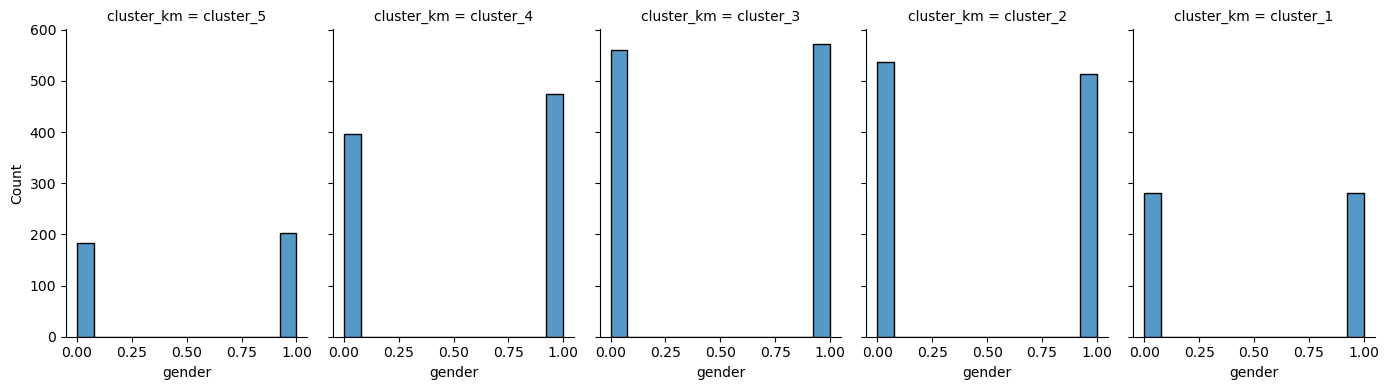

Распределение признака near_location по кластерам 



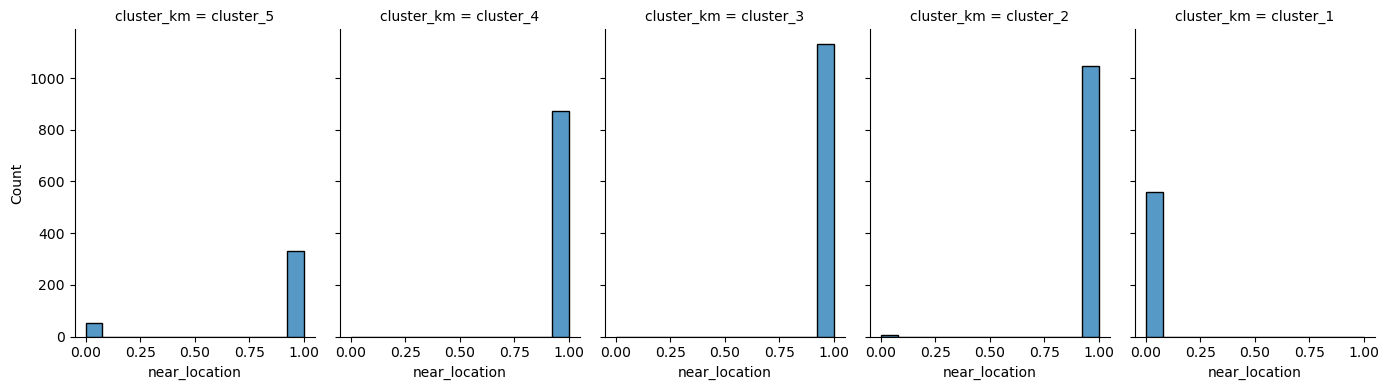

Распределение признака partner по кластерам 



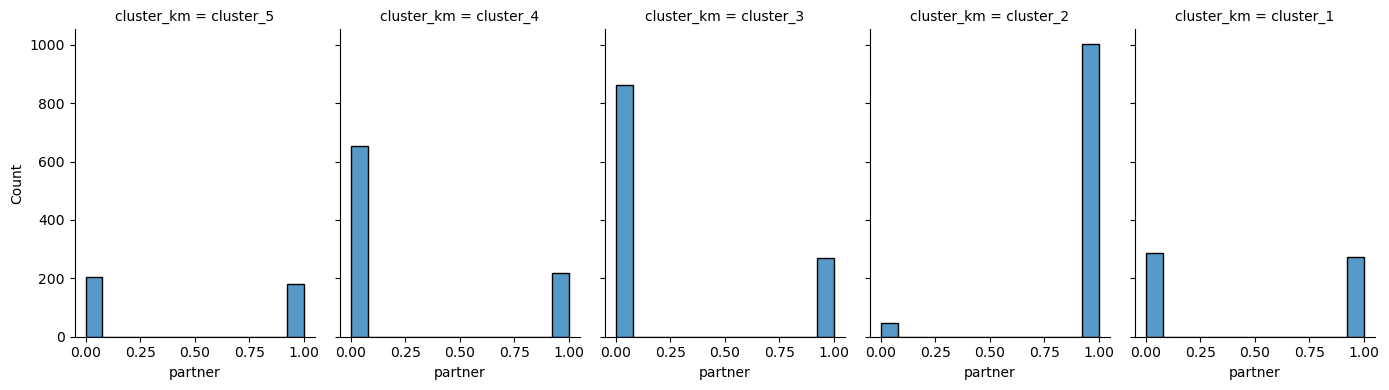

Распределение признака promo_friends по кластерам 



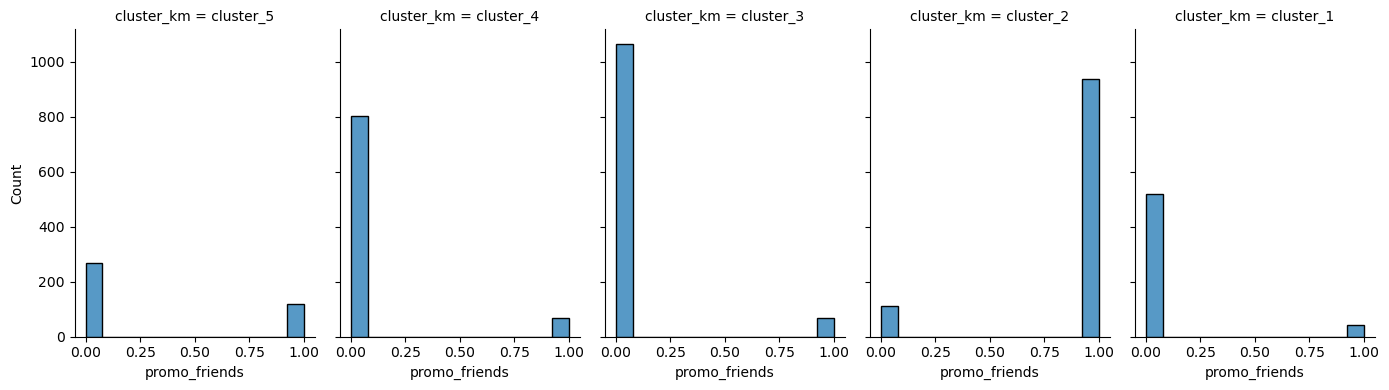

Распределение признака phone по кластерам 



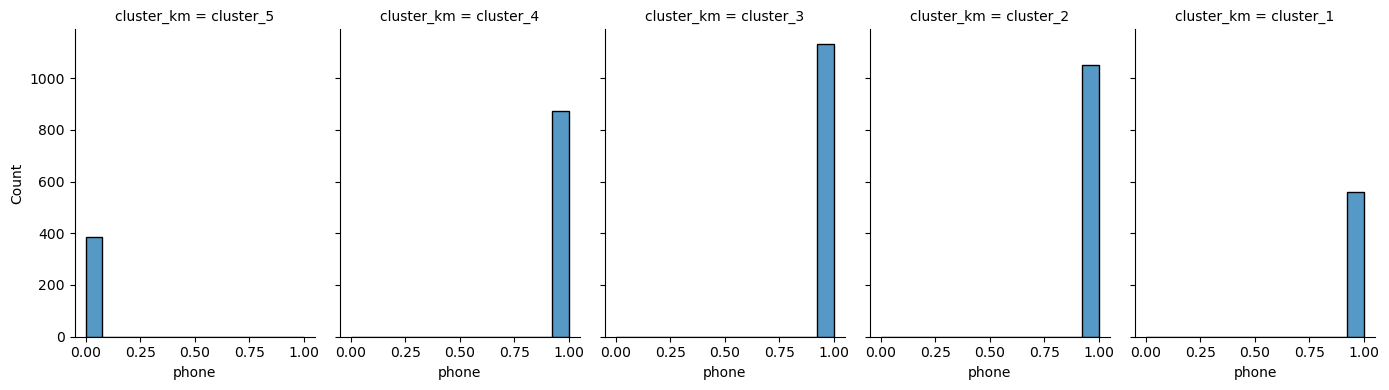

Распределение признака contract_period по кластерам 



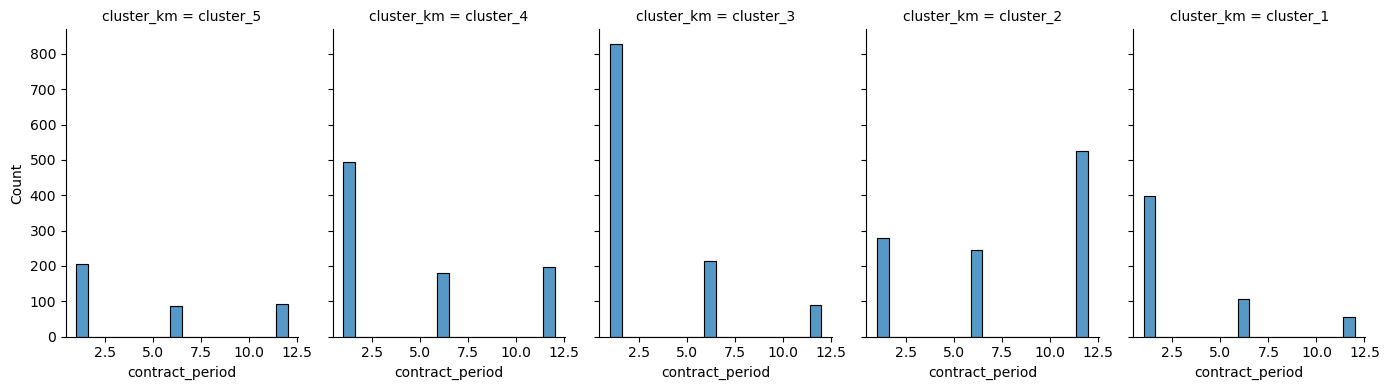

Распределение признака group_visits по кластерам 



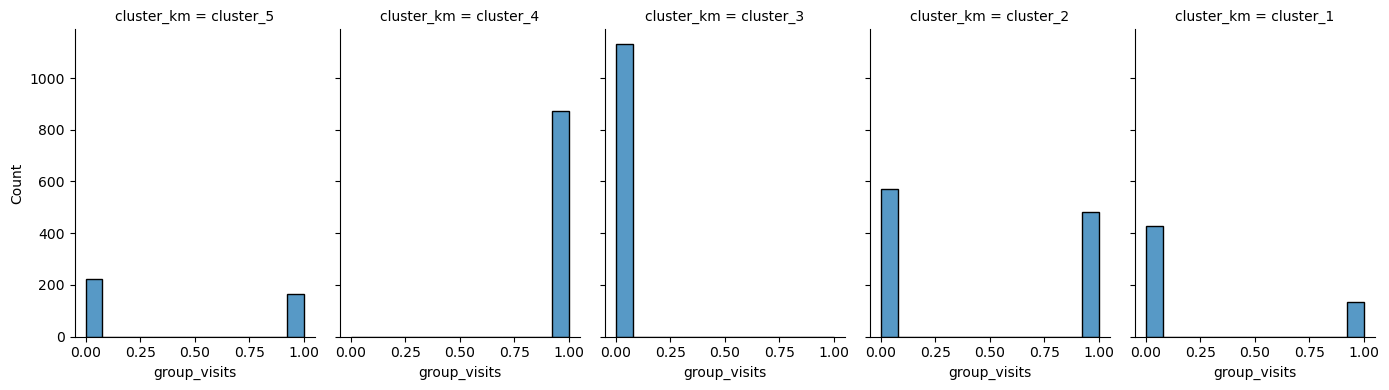

Распределение признака age по кластерам 



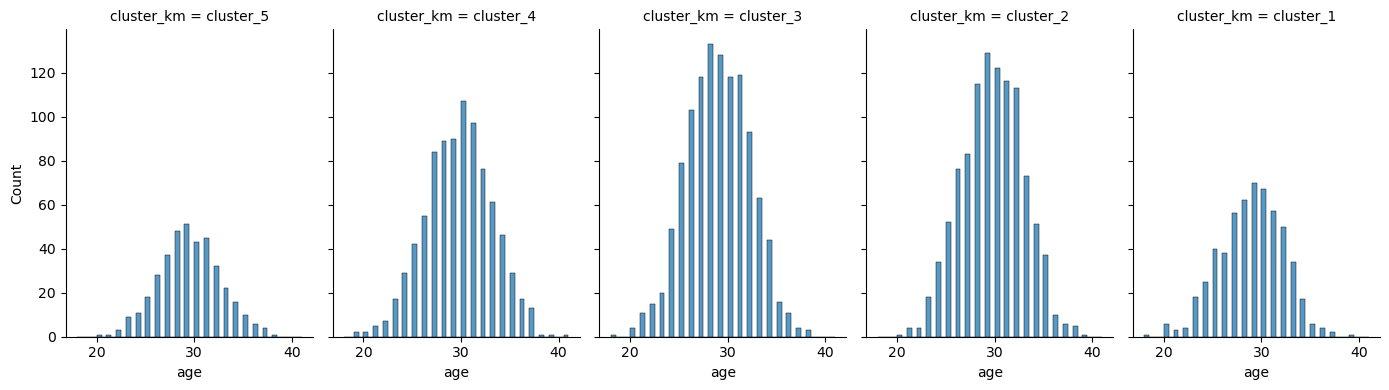

Распределение признака avg_additional_charges_total по кластерам 



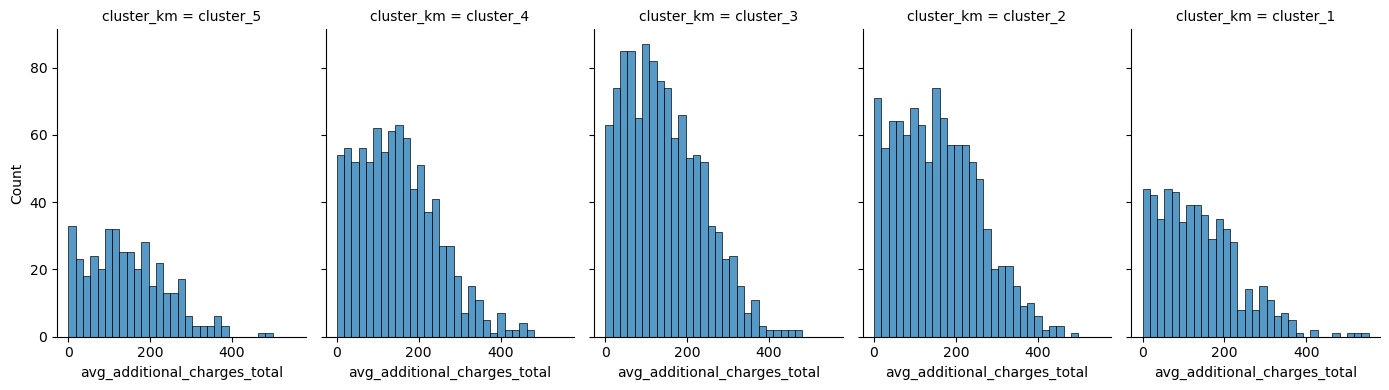

Распределение признака month_to_end_contract по кластерам 



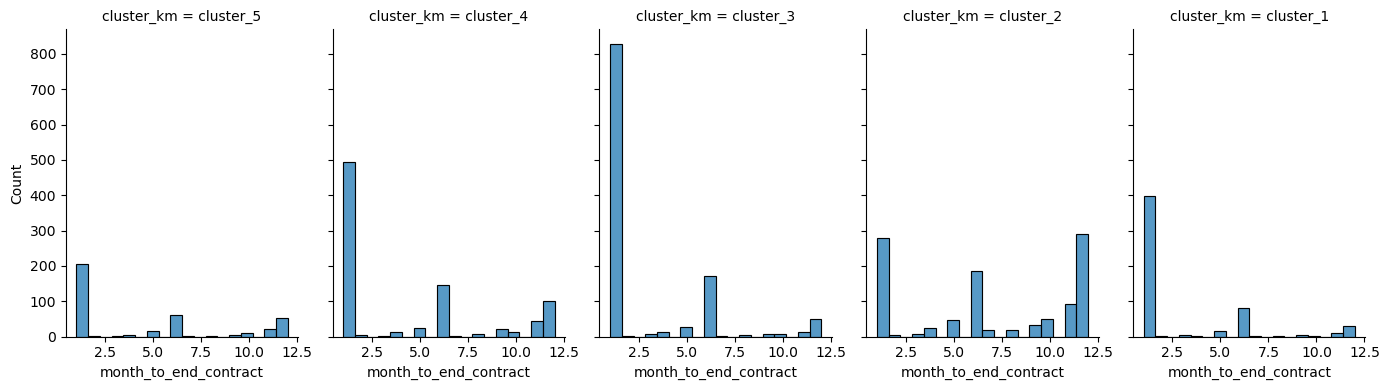

Распределение признака lifetime по кластерам 



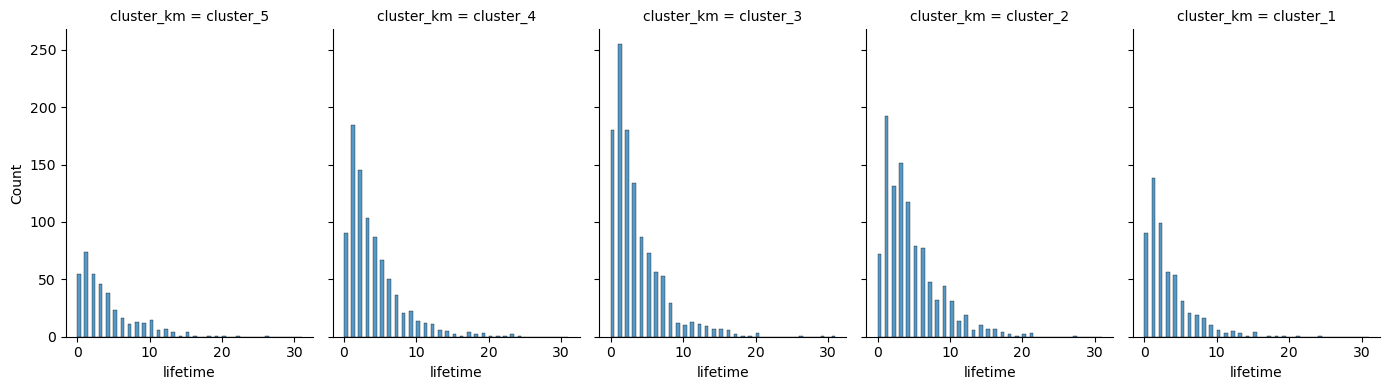

Распределение признака avg_class_frequency_total по кластерам 



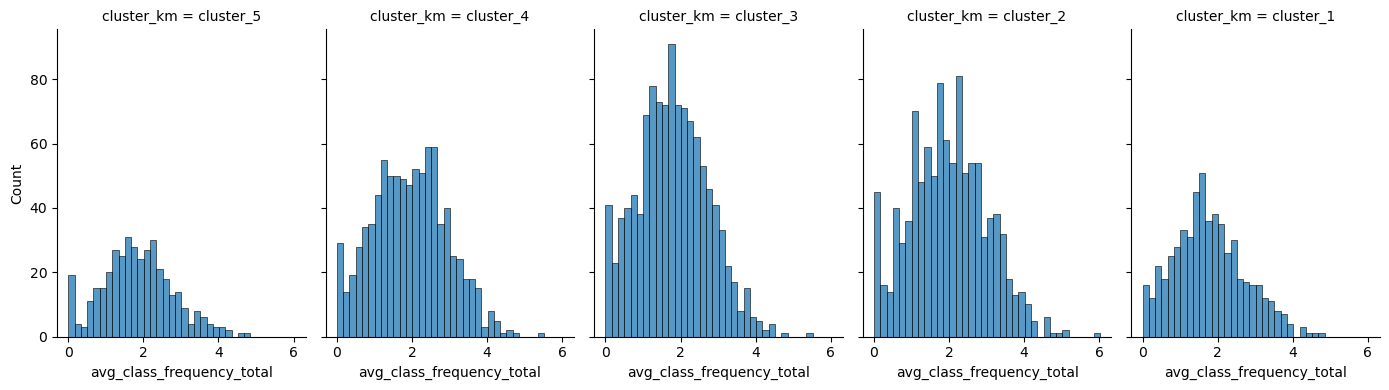

Распределение признака avg_class_frequency_current_month по кластерам 



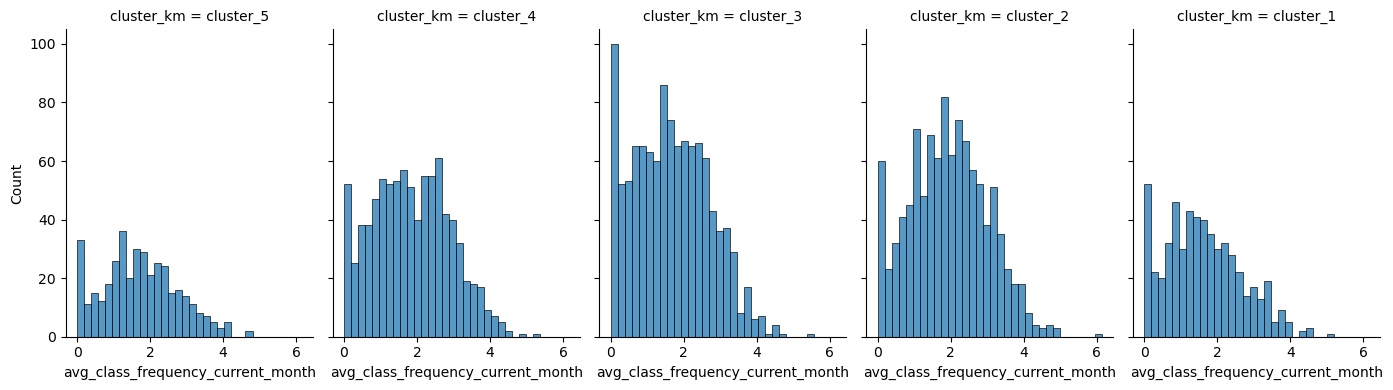

Распределение признака churn по кластерам 



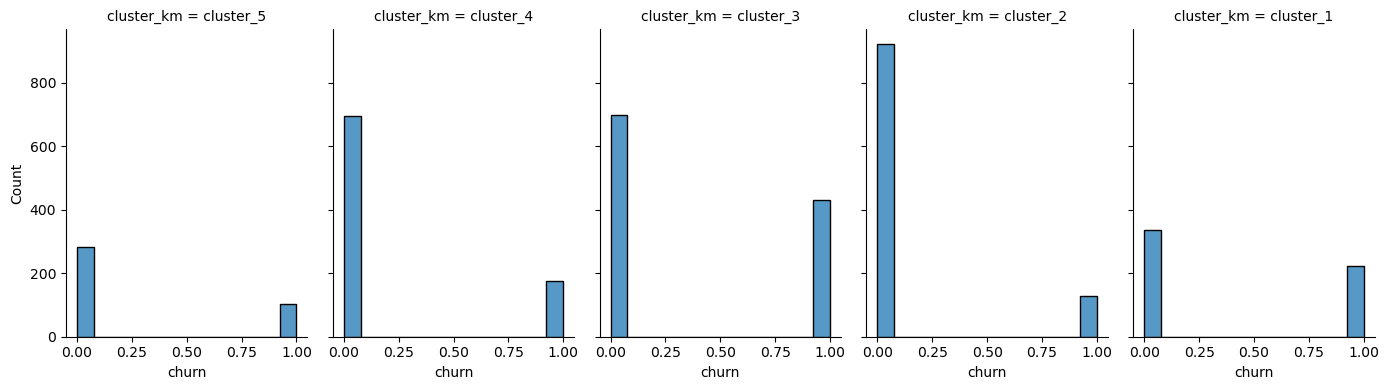

In [39]:
# Функция для построения гистрограмм по каждому признаку для каждого класса

def get_hist(x, key_cols):
    for c in key_cols[:-1]:
        print('Распределение признака {} по кластерам \n'.format(c))
        sns.displot(data=x, x=x[c], col='cluster_km', height=4, aspect=0.7)
        plt.show()
        
get_hist(df, df.columns)

## Доля оттока для каждого кластера

In [40]:
(df.groupby('cluster_km')['churn'].agg(['count','sum', 'mean']).reset_index()
.sort_values(by='mean', ascending=False)
.style
.format({'mean': '{:.2f}'})
.highlight_max(color='coral', subset='mean')
.highlight_min(color='yellowgreen', subset='mean'))

,cluster_km,count,sum,mean
0,cluster_1,561,224,0.40
2,cluster_3,1132,432,0.38
4,cluster_5,386,103,0.27
3,cluster_4,871,175,0.20
1,cluster_2,1050,127,0.12


* Первый кластер имеет самую высокую долю оттока. 

* Второй кластер имеет самых надежных клиентов. 

## Вывод: описание кластеров клиентов

На основе алгоритма K-means мы провели кластеризацию клиентов и выделили 5 кластеров клиентов. 
Все кластеры имеют примерно одинавокое распределение по возрасту, в среднем 29-30 лет.


`1 кластер` 

характеризуется:

* **самой высокой долей оттока - 0.40**,

* приблизительно равным распределением между мужчинами и женщинами,
    
* клиентами, живущими или работающими **вдали от фитнес-центра**,
 
* приблизительно равным количеством между клиентами-сотрудниками компании партнеров-клуба и обычными посетителями,
    
* клиентами, большинство из которых пришли не по промо-акции "Приведи друга"
    
* клиентами, **большинство из которых имеет абонемент длительностью на 1 месяц (среднее равно 3.03 месяца), абонемент на 12 месяцев берет лишь самая малая часть**.  
    
* клиентами, где примерно лишь треть посещает групповые занятия,
    
* **самой низкой суммарной выручкой** за дополнительные услуги в фитнес-центре (в среднем 137.54 денежных единиц)
    
* клиентами, **большинство из которых имеют абонемент со скоро истекающим сроком действия (в среднем до истечения срока остается 2.85 месяцев)**.
    
* **самым коротким сроком от начала пользования услугами  (в среднем 3 месяца)**,
    
* **самой низкой частотой посещения клуба** - среднее за месяц и за весь период меньше, чем для всех остальных кластеров (1.61 и 1.77)

``2 кластер`` 

характеризуется:
    
* **самой низкой долей оттока - 0.12**, 

* приблизительно равным распределением между мужчинами и женщинами,
   
* клиентами, которые посещают клуб только вблизи от дома или работы,
    
* клиентами, большинство из которых (около 96%) пришло от компаний-партнёров клуба, 
    
* клиентами, большинство из которых (около 89%) пришло по промо-акции от друзей,
    
* клиентами, примерно половина из которых имеет абонемент длительностью на 12 месяцев,
    
* посещаемостью групповых занятий (примерно 46%  клиентов кластера посещают групповые занятия),

* **самой высокой суммарной выручкой** за дополнительные услуги в фитнес-центре (в среднем 156 денежных единиц)
    
* **большим количеством клиентов с абонементом на 12 месяцев** (средняя длительность абонемента самая высокая - 7.7). 
    
* **самым длительным сроком до конца текущего абонемента** (в среднем 7 месяцев),

* **самым длительным сроком от начала пользования услугами** (в среднем 4.38 месяцев),
   
* **самой высокой частотой посещения клуба** в месяц и за весь период (1.93 и 1.98 в среднем)
    

``3 кластер`` 

близок к первому. Кластер характеризуется:
    
* высокой долей оттока  - 0.38 (на втором месте после 1 кластера)
    
* клиентами, живущими или работающими вблизи к клубу,
        
* клиентами, большинство из которых (около 76%) пришли не от компаний-партнёров клуба, 
    
* клиентами, большинство из которых (около 94%) пришло не по промо-акции от друзей,

* клиентами, большинство из которых имеет абонемент длительностью на 1 месяц (среднее равно 2.82 месяца),
        
* клиентами, не посещяющими групповые занятия,
    
* небольшой суммарной суммой затрат на дополнительные услуги центра (чуть больше, чем в 1 кластере - в среднем 143.38),
    
* самым коротким сроком до конца текущего абонемента (в среднем 2.6 месяцев),   
 
* небольшим сроком от начала пользования услугами  (в среднем 3.3 месяца),
    
* нечастым посещением клуба в месяц и за весь период (1.65 и 1.80 в среднем)

``4 кластер``  

характеризуется:
    
* сравнительно небольшой долей оттока - 0.20
    
* клиентами, живущими или работающими вблизи к клубу,
    
* клиентами, большинство из которых (около 75%) пришли не от компаний-партнёров клуба, 
    
* клиентами, большинство из которых (около 94%) пришло не по промо-акции от друзей,

* клиентами, примерно половина из которых имеет абонемент длительностью на 1 месяцев,
    
* клиентами, которые посещают групповые занятия (все клиенты),
    
* средней суммарной суммой затрат на дополнительные услуги центра (148 денежных единиц в среднем),

* средним сроком до конца текущего абонемента (в среднем 4.17 месяцев),

* длительным сроком от начала пользования услугами (в среднем 3.76 месяцев),
       
* хорошей частотой посещения клуба в месяц и за весь период (1.85 и 1.94 в среднем)
  

``5 кластер``

близок к четвертому, он  характеризуется:
    
* сравнительно небольшой долей оттока - 0.27,
 
* распределением клиентов относительно признака близости фитнес-клуба: 86% посещают клуб вблизи к дому или офису. 
    
* клиентами, примерно 47% из которых пришли от компаний-партнёров клуба, 

* клиентами, примерно 31 % из которых пришло по промо-акции от друзей,

* клиентами, примерно треть из которых имеет абонемент длительностью на 6 месяцев и на 12 месяцев,

* клиентами, примерно 43% из которых посещают групповые занятия,
    
* средней суммарной суммой затрат на дополнительные услуги центра (144 денежных единиц в среднем), 

* средним сроком до конца текущего абонемента (в среднем 4.47 месяцев),

* длительным сроком от начала пользования услугами (около 4 месяцев в среднем),
   
* хорошей частотой посещения клуба в месяц и за весь период (1.72 и 1.85 в среднем)

<a name='stage_5'></a>
# Шаг 5. Общий вывод и рекомендации отделу по работе к клиентами
[Назад к оглавлению](#contents)

Мы проанализировали данные о клиентах сети фитнес-центров «Культурист-датасаентист». 

Эти данные содержат в себе информацию о 4 000 клиентов по следующим 14 признакам:

* пол, 
* близость к фитнес-центру, 
* принадлежность к компании-партнёру фитнес-центра, 
* факт первоначальной записи в рамках промо-акции «приведи друга», 
* наличие контактного телефона, 
* возраст, 
* время с момента первого обращения в фитнес-центр, 
* длительность текущего действующего абонемента, 
* срок до окончания действующего абонемента, 
* факт посещения групповых занятий, 
* средняя частота посещений в неделю за все время с начала действия абонемента и за предыдущий месяц, 
* суммарная выручка от других услуг фитнес-центра.

По этим показателям мы построили лучшую модель на основе **алгоритма логистической регрессии**, предсказывающую отток клиентов.  Значения метрик качества модели: *точность - 0.90, полнота - 0.85, F1-мера - 0.85, ROC_AUC: 0.98*.


**Анализ данных позволяет сделать следующие выводы:**

* Около 27% клиентов ушло в отток.

* Среди тех клиентов, кто ушел, гораздо меньше таких, кто работает в компании-партнере клуба (среднее близко к 0.4).

* В среднем длительность абонемента у людей, ушедших в отток, составляет 1.7 месяцев, а у оставшихся клиентов - 5.7 месяцев. То есть уходят в большей степени те, у кого короткая длительность абонемента.

* Так же большой разрыв среди лояльных и нет по сроку окончания текущего абонемента. У ушедших в отток он в среднем составляем -1.6 месяцев, а у лояльных клиентов - 5.2 месяцев. То есть в отток склонны больше уходить те, у кого скоро истекает действие абонемента.

* Время с момента первого обращения в фитнес-центр для уходящих в отток равно примерно 1 месяцу, а для тех, кто остался, чуть больше 5 месяцев. Значит лояльные первые месяцы клиенты, скорее всего, не уйдут в отток после длительного периода пользования услугами фитнес-центра.

* Среди клиентов в оттоке совсем мало людей, посещающих групповые занятия (среднее около 0.3 в сравнении с группой лояльных, где около 0.5).

* Клиенты в оттоке значительно меньше тратят на дополнительные услуги в фитнес-центре - в среднем 115 денежных единиц, в то время как лояльные клиенты - в среднем тратят 158.

* Пол, контактный номер телефона не влияют на факт оттока. 

**Кластеризация алгоритмом K-means выделила 5 кластеров клиентов**. Наиболее яркие: 1 кластер и 2 кластер.

* 1 кластер - это **самые ненадежные клиенты** (доля оттока - 0.4). Среди них те, кто посещают фитнес-клуб далеко от дома или работы, в большинстве случаев имеют абонемент на 1 месяц и доля клиентов с абонементом на 12 месяцев самая маленькая среди всех кластеров. У большинства этих клиентов имеется абонемент со скоро истекающим сроком действия (в среднем до срока истечения остается 2.85 месяцев) Эти клиенты реже всех посещают клуб - среднее за месяц и за весь период меньше, чем для всех остальных кластеров (1.61 и 1.77), а также примерно лишь треть из них посещает групповые занятия. В этом кластере самые экономные клиенты - суммарная выручка за дополнительные услуги ниже всех  (в среднем 137.54 денежных единиц). 

* 2 кластер - это **самые лояльные клиенты** (доля оттока - 0.1). Это те клиенты, которые посещают клуб только рядом с домом или с офисом. Большинство из них сотрудники компаний-партнеров фитнес-клуба. У этих клиентов самый длительный срок до конца текущего абонемента (в среднем 7 месяцев) и среднее по длительности абонемента самое высокое - 7.7 месяцев. Они дольше всех посещают клуб - в среднем срок от начала использования услуг составляет 4.38 месяцев. Клиенты 2 кластера чаще всех посещают клуб (1.93 за месяц и 1.98 за весь период в среднем) и больше всех тратят на дополнительные услуги (в среднем 156 денежных единиц)

**Рекомендации отделу по работе с клиентами**

На основе представленных выводов, предлагаем следующие рекомендации для стратегии взаимодействия с пользователями сети фитнес-центров «Культурист-датасаентист» и их удержания:

1. Рекомендуется привлекать клиентов из ближайших спальных районов или сотрудников ближайших бизнес-центров (может, рассмотреть возможность заключения договоров о сотрудничестве с крупными компаниями ближайших бизнес-центров).

2. Возможно, следует предлагать более длительные абонементы (на 9, 12 месяцев), поскольку клиенты, которые имеют более длительные абонементы и довольно долго пользуются услугами, меньше всех склонны к оттоку. 

3. Рекомендуется сделать длительные абонементы более выгодными по цене, чем абонементы на 1 месяц. Ввести абонемент на 3 месяца. Чем длиннее срок действия абонемента, тем больше скидка. 

4. Следует клиентам, у которых скоро истекает срок действия абонемента, предлагать покупку нового абонемента или его продление со скидкой или по акции и, возможно, предложить бесплатно посетить групповое занятие. 

# Спасибо, что проверили мой проект!